In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ORRFA import *
import interpretableai
from interpretableai import iai
import pandas as pd
import json
from HR import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv("/Users/ryanlucas/Desktop/kc_house_data.csv")

In [3]:
dataset

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [4]:
def data_processing(dataset):
    dataset['date'] = pd.to_datetime(dataset['date'])
    dataset['year'] = dataset['date'].dt.year
    dataset['month'] = dataset['date'].dt.month
    dataset['day'] = dataset['date'].dt.day
    dataset = dataset.drop(["date","day",'id', 'zipcode'],axis=1)
    pd.get_dummies(dataset, columns=['month'])

    features = dataset.copy()
    features = features.drop('price', axis = 1)
    diagnosis = dataset.loc[:, "price"]

    features_train, features_test, diagnosis_train, diagnosis_test = train_test_split(features, diagnosis, test_size = 0.3, shuffle=True)

    orig_columns = features.copy().columns

    sc = StandardScaler()
    features_train = pd.DataFrame(sc.fit_transform(features_train))
    features_train.columns = orig_columns

    features_test = pd.DataFrame(sc.fit_transform(features_test))
    features_test.columns = orig_columns

    return features_train, diagnosis_train, features_test, diagnosis_test

In [53]:
features, diagnosis, features_test, diagnosis_test = data_processing(dataset)

In [6]:
features

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,year,month
0,-0.388533,-0.795937,0.339383,-0.272423,0.014862,-0.088282,-0.307294,-0.631108,1.148136,-0.117110,0.924246,-1.191778,-0.213569,0.722974,-0.469630,0.531876,-0.320145,-0.687737,1.433150
1,-0.388533,-1.444230,-1.152289,-0.248855,0.014862,-0.088282,-0.307294,-0.631108,-1.415472,-1.046601,-0.432561,-1.532605,-0.213569,-0.193228,-0.434326,-1.100651,-0.197428,1.454044,-1.468202
2,-0.388533,-0.471790,-0.509890,-0.077245,-0.910419,-0.088282,2.296484,-0.631108,-0.560936,-0.696533,0.245843,0.444187,-0.213569,0.795495,0.533010,-0.546758,-0.122803,-0.687737,0.788405
3,0.681188,1.148943,2.614998,0.678110,0.940142,-0.088282,-0.307294,-0.631108,1.148136,3.250787,-0.658695,0.546435,-0.213569,1.517830,0.886053,1.683391,1.064598,-0.687737,0.143660
4,-1.458253,-1.444230,-1.282946,-0.242471,-0.910419,-0.088282,-0.307294,0.904686,-1.415472,-1.070744,-0.658695,-0.510126,-0.213569,-0.353347,-1.225141,-0.736248,-0.222266,-0.687737,-0.178712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15124,-0.388533,0.176503,-0.444561,-0.247774,0.940142,-0.088282,-0.307294,-0.631108,0.293600,-0.141253,-0.658695,0.546435,-0.213569,0.065262,1.387373,-0.196930,-0.273193,1.454044,-1.468202
15125,0.681188,0.176503,2.495229,0.190678,1.865423,-0.088282,3.598373,0.904686,2.002672,2.273011,0.924246,-2.180174,4.677631,0.919714,-0.010675,1.450173,0.373955,-0.687737,0.788405
15126,-0.388533,-1.444230,-0.847422,-0.142304,-0.910419,-0.088282,-0.307294,0.904686,-0.560936,-0.587891,-0.658695,0.205609,-0.213569,1.410844,0.991966,-0.998618,-0.097009,1.454044,-1.468202
15127,0.681188,0.500650,0.067180,-0.180260,0.940142,-0.088282,-0.307294,-0.631108,0.293600,0.426099,-0.658695,0.853178,-0.213569,1.131532,-0.879160,-0.430149,-0.181237,-0.687737,0.788405


In [7]:
print(len(dataset))
print(len(features))
print(len(features_test))

21613
15129
6484


In [8]:
np.random.seed(1)
rules = {}

# for j in range(2, 7):

for j in [5]:

    for i in range(1,51):

        n = max(5, j+1)

        #################
        sampled_features = features.copy().sample(n=int(n),axis='columns')

        OCT_H = iai.GridSearch(
                  iai.OptimalTreeRegressor(
                      max_depth = j, cp = 0.00000000001))

        OCT_H.fit(sampled_features, diagnosis)
        OCT_H.write_json(f"tre.json")

        ######################
        f = open(f"tre.json")
        data = json.load(f)

        paths = gen_paths(data)

        sub_paths = gen_subpaths(paths)

        names = sampled_features.columns

        rule_features_new = gen_features(
                    sub_paths, data, sampled_features, names)

        rules[f"tre_{i}_{j}"] = rule_features_new

        print(f"Tree: {i}")


[ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.


Tree: 1
Tree: 2
Tree: 3
Tree: 4
Tree: 5
Tree: 6
Tree: 7
Tree: 8
Tree: 9
Tree: 10
Tree: 11
Tree: 12
Tree: 13
Tree: 14
Tree: 15
Tree: 16
Tree: 17
Tree: 18
Tree: 19
Tree: 20
Tree: 21
Tree: 22
Tree: 23
Tree: 24
Tree: 25
Tree: 26
Tree: 27
Tree: 28
Tree: 29
Tree: 30
Tree: 31
Tree: 32
Tree: 33
Tree: 34
Tree: 35
Tree: 36
Tree: 37
Tree: 38
Tree: 39
Tree: 40
Tree: 41
Tree: 42
Tree: 43
Tree: 44
Tree: 45
Tree: 46
Tree: 47
Tree: 48
Tree: 49
Tree: 50


In [9]:
big_df = pd.DataFrame()
for tree in rules.keys():

    big_df = pd.concat([big_df, rules[tree]],axis =1)


In [10]:
df = big_df.loc[:,~big_df.columns.duplicated()].copy()

In [11]:
for column in df.columns:
    if df[column].sum() == len(df):
        del df[column]


In [12]:
df

,(features['sqft_lot'] < -0.21061677717114685),(features['sqft_lot'] < -0.21061677717114685) & (features['grade'] < -0.9882037745420109),(features['sqft_basement'] >= 1.5687291793752007),(features['sqft_basement'] >= 1.5687291793752007) & (features['long'] >= 0.09170728156580044),(features['sqft_basement'] >= 1.5687291793752007) & (features['long'] >= 0.09170728156580044) & (0 >= 0.0),(features['sqft_living'] >= 4.465977350418138),(features['sqft_living'] >= 4.465977350418138) & (features['lat'] < -0.24097628145039884),(features['sqft_living'] < 0.08677845194990619),(features['sqft_living'] < 0.08677845194990619) & (features['sqft_living'] < -0.8637537803630642),(features['sqft_living'] < 0.08677845194990619) & (0 >= 0.0),...,(features['long'] >= -0.6461515912620641),(features['long'] >= -0.6461515912620641) & (features['bathrooms'] < -0.30971657872528846),(features['grade'] < 0.7208682617011477),(features['grade'] < 0.7208682617011477) & (features['yr_built'] >= -0.0159284221362177),(features['grade'] < 0.7208682617011477) & (features['yr_built'] >= -0.0159284221362177) & (0 >= 0.0),(features['waterfront'] >= 5.619508120660568),(features['waterfront'] >= 5.619508120660568) & (features['bedrooms'] >= 1.216047774165065),(features['long'] >= -0.6496820164909223),(features['long'] >= -0.6496820164909223) & (features['sqft_above'] < 1.7116944612348601),(features['long'] >= -0.6496820164909223) & (features['sqft_above'] < 1.7116944612348601) & (0 >= 0.0)
0,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,1
1,1,1,0,0,0,0,0,1,1,1,...,1,1,1,0,0,0,0,1,1,1
2,0,0,0,0,0,0,0,1,0,1,...,1,1,1,1,1,0,0,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,1,1,0,0,0,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15124,1,0,0,0,0,0,0,1,0,1,...,1,0,1,1,1,0,0,1,1,1
15125,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
15126,0,0,0,0,0,0,0,1,0,1,...,1,1,1,1,1,0,0,1,1,1
15127,0,0,0,0,0,0,0,1,0,1,...,0,0,1,1,1,0,0,0,0,0


In [13]:
features_for_robust_reg = df

In [14]:
rule_features = features_for_robust_reg.copy()
features_for_robust_reg = pd.concat([features, features_for_robust_reg], axis = 1)

In [15]:
features_for_robust_reg.sum()

bedrooms                                                                                                          -2.490452e-12
bathrooms                                                                                                          2.614797e-12
sqft_living                                                                                                        4.902745e-13
sqft_lot                                                                                                          -9.947598e-14
floors                                                                                                             2.870593e-12
waterfront                                                                                                         3.552714e-13
view                                                                                                              -8.526513e-14
condition                                                                                               

In [16]:
features_for_robust_reg.insert(loc = 0, column = 'Intercept', value = [1 for i in range(len(features_for_robust_reg))])

In [17]:
features_for_robust_reg

,Intercept,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,(features['long'] >= -0.6461515912620641),(features['long'] >= -0.6461515912620641) & (features['bathrooms'] < -0.30971657872528846),(features['grade'] < 0.7208682617011477),(features['grade'] < 0.7208682617011477) & (features['yr_built'] >= -0.0159284221362177),(features['grade'] < 0.7208682617011477) & (features['yr_built'] >= -0.0159284221362177) & (0 >= 0.0),(features['waterfront'] >= 5.619508120660568),(features['waterfront'] >= 5.619508120660568) & (features['bedrooms'] >= 1.216047774165065),(features['long'] >= -0.6496820164909223),(features['long'] >= -0.6496820164909223) & (features['sqft_above'] < 1.7116944612348601),(features['long'] >= -0.6496820164909223) & (features['sqft_above'] < 1.7116944612348601) & (0 >= 0.0)
0,1,-0.388533,-0.795937,0.339383,-0.272423,0.014862,-0.088282,-0.307294,-0.631108,1.148136,...,1,1,0,0,0,0,0,1,1,1
1,1,-0.388533,-1.444230,-1.152289,-0.248855,0.014862,-0.088282,-0.307294,-0.631108,-1.415472,...,1,1,1,0,0,0,0,1,1,1
2,1,-0.388533,-0.471790,-0.509890,-0.077245,-0.910419,-0.088282,2.296484,-0.631108,-0.560936,...,1,1,1,1,1,0,0,1,1,1
3,1,0.681188,1.148943,2.614998,0.678110,0.940142,-0.088282,-0.307294,-0.631108,1.148136,...,1,0,0,0,0,0,0,1,0,0
4,1,-1.458253,-1.444230,-1.282946,-0.242471,-0.910419,-0.088282,-0.307294,0.904686,-1.415472,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15124,1,-0.388533,0.176503,-0.444561,-0.247774,0.940142,-0.088282,-0.307294,-0.631108,0.293600,...,1,0,1,1,1,0,0,1,1,1
15125,1,0.681188,0.176503,2.495229,0.190678,1.865423,-0.088282,3.598373,0.904686,2.002672,...,1,0,0,0,0,0,0,1,0,0
15126,1,-0.388533,-1.444230,-0.847422,-0.142304,-0.910419,-0.088282,-0.307294,0.904686,-0.560936,...,1,1,1,1,1,0,0,1,1,1
15127,1,0.681188,0.500650,0.067180,-0.180260,0.940142,-0.088282,-0.307294,-0.631108,0.293600,...,0,0,1,1,1,0,0,0,0,0


In [18]:
features_for_robust_reg.sum(axis =0)

Intercept                                                                                                          1.512900e+04
bedrooms                                                                                                          -2.490452e-12
bathrooms                                                                                                          2.614797e-12
sqft_living                                                                                                        4.902745e-13
sqft_lot                                                                                                          -9.947598e-14
floors                                                                                                             2.870593e-12
waterfront                                                                                                         3.552714e-13
view                                                                                                    

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
features.insert(loc = 0, column = 'Intercept', value = [1 for i in range(len(features))])

In [21]:
reg_baseline = LinearRegression().fit(features.copy()
, diagnosis)

In [22]:
θ_baseline = reg_baseline.coef_

In [23]:
predictions_baseline = reg_baseline.predict(features.copy())

In [24]:
(diagnosis - predictions_baseline).describe()

count    1.512900e+04
mean    -4.432231e-12
std      2.041834e+05
min     -1.318575e+06
25%     -9.974114e+04
50%     -8.682936e+03
75%      7.770029e+04
max      4.320031e+06
Name: price, dtype: float64

In [65]:
SSE_model = sum((diagnosis - predictions_baseline)**2)
SSE_mean = sum((diagnosis - diagnosis.mean())**2)

1 - SSE_model/SSE_mean

-0.6970435645881476

In [66]:
features_test.insert(loc = 0, column = 'Intercept', value = [1 for i in range(len(features_test))])

In [67]:
predictions_test_baseline = reg_baseline.predict(features_test)

In [68]:
SSE_model = sum((diagnosis_test - predictions_test_baseline)**2)
SSE_mean = sum((diagnosis_test - diagnosis.mean())**2)

1 - SSE_model/SSE_mean

0.688952645055533

In [69]:
reg_trees = LinearRegression().fit(features.copy()
, diagnosis)

In [70]:
from sklearn import linear_model

In [71]:
big_df

,(features['sqft_lot'] < -0.21061677717114685),(features['sqft_lot'] < -0.21061677717114685) & (features['grade'] < -0.9882037745420109),(features['sqft_basement'] >= 1.5687291793752007),(features['sqft_basement'] >= 1.5687291793752007) & (features['long'] >= 0.09170728156580044),(features['sqft_basement'] >= 1.5687291793752007) & (features['long'] >= 0.09170728156580044) & (0 >= 0.0),(features['sqft_living'] >= 4.465977350418138),(features['sqft_living'] >= 4.465977350418138) & (features['lat'] < -0.24097628145039884),(features['sqft_living'] < 0.08677845194990619),(features['sqft_living'] < 0.08677845194990619) & (features['sqft_living'] < -0.8637537803630642),(features['sqft_living'] < 0.08677845194990619) & (0 >= 0.0),...,(features['long'] >= -0.6461515912620641),(features['long'] >= -0.6461515912620641) & (features['bathrooms'] < -0.30971657872528846),(features['grade'] < 0.7208682617011477),(features['grade'] < 0.7208682617011477) & (features['yr_built'] >= -0.0159284221362177),(features['grade'] < 0.7208682617011477) & (features['yr_built'] >= -0.0159284221362177) & (0 >= 0.0),(features['waterfront'] >= 5.619508120660568),(features['waterfront'] >= 5.619508120660568) & (features['bedrooms'] >= 1.216047774165065),(features['long'] >= -0.6496820164909223),(features['long'] >= -0.6496820164909223) & (features['sqft_above'] < 1.7116944612348601),(features['long'] >= -0.6496820164909223) & (features['sqft_above'] < 1.7116944612348601) & (0 >= 0.0)
0,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,1
1,1,1,0,0,0,0,0,1,1,1,...,1,1,1,0,0,0,0,1,1,1
2,0,0,0,0,0,0,0,1,0,1,...,1,1,1,1,1,0,0,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,1,1,0,0,0,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15124,1,0,0,0,0,0,0,1,0,1,...,1,0,1,1,1,0,0,1,1,1
15125,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
15126,0,0,0,0,0,0,0,1,0,1,...,1,1,1,1,1,0,0,1,1,1
15127,0,0,0,0,0,0,0,1,0,1,...,0,0,1,1,1,0,0,0,0,0


In [72]:
features_for_robust_reg


,Intercept,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,(features['long'] >= -0.6461515912620641),(features['long'] >= -0.6461515912620641) & (features['bathrooms'] < -0.30971657872528846),(features['grade'] < 0.7208682617011477),(features['grade'] < 0.7208682617011477) & (features['yr_built'] >= -0.0159284221362177),(features['grade'] < 0.7208682617011477) & (features['yr_built'] >= -0.0159284221362177) & (0 >= 0.0),(features['waterfront'] >= 5.619508120660568),(features['waterfront'] >= 5.619508120660568) & (features['bedrooms'] >= 1.216047774165065),(features['long'] >= -0.6496820164909223),(features['long'] >= -0.6496820164909223) & (features['sqft_above'] < 1.7116944612348601),(features['long'] >= -0.6496820164909223) & (features['sqft_above'] < 1.7116944612348601) & (0 >= 0.0)
0,1,-0.388533,-0.795937,0.339383,-0.272423,0.014862,-0.088282,-0.307294,-0.631108,1.148136,...,1,1,0,0,0,0,0,1,1,1
1,1,-0.388533,-1.444230,-1.152289,-0.248855,0.014862,-0.088282,-0.307294,-0.631108,-1.415472,...,1,1,1,0,0,0,0,1,1,1
2,1,-0.388533,-0.471790,-0.509890,-0.077245,-0.910419,-0.088282,2.296484,-0.631108,-0.560936,...,1,1,1,1,1,0,0,1,1,1
3,1,0.681188,1.148943,2.614998,0.678110,0.940142,-0.088282,-0.307294,-0.631108,1.148136,...,1,0,0,0,0,0,0,1,0,0
4,1,-1.458253,-1.444230,-1.282946,-0.242471,-0.910419,-0.088282,-0.307294,0.904686,-1.415472,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15124,1,-0.388533,0.176503,-0.444561,-0.247774,0.940142,-0.088282,-0.307294,-0.631108,0.293600,...,1,0,1,1,1,0,0,1,1,1
15125,1,0.681188,0.176503,2.495229,0.190678,1.865423,-0.088282,3.598373,0.904686,2.002672,...,1,0,0,0,0,0,0,1,0,0
15126,1,-0.388533,-1.444230,-0.847422,-0.142304,-0.910419,-0.088282,-0.307294,0.904686,-0.560936,...,1,1,1,1,1,0,0,1,1,1
15127,1,0.681188,0.500650,0.067180,-0.180260,0.940142,-0.088282,-0.307294,-0.631108,0.293600,...,0,0,1,1,1,0,0,0,0,0


In [73]:
lasso_trees = linear_model.Ridge(alpha = 1).fit(features_for_robust_reg.copy()
, diagnosis)

In [74]:
predictions_lasso_trees = lasso_trees.predict(features_for_robust_reg)

In [75]:
SSE_model = sum((predictions_lasso_trees - diagnosis)**2)
SSE_mean = sum((diagnosis - diagnosis.mean())**2)

1 - SSE_model/SSE_mean

0.003787401536901158

In [76]:
features = features_test
for rule in rule_features.columns:

    index_feature = list(features.loc[eval(rule)].index)

    print(index_feature)
    new_feature = [1 if i in index_feature else 0 for i in range(features.index[0], features.index[-1]+1)]

    features[rule] = new_feature




[1, 3, 7, 9, 12, 13, 14, 16, 17, 18, 21, 22, 28, 32, 40, 43, 47, 50, 53, 56, 57, 61, 62, 64, 65, 66, 69, 74, 75, 76, 77, 78, 88, 89, 93, 94, 95, 96, 98, 99, 104, 108, 112, 116, 117, 118, 119, 122, 124, 125, 126, 127, 130, 132, 133, 138, 140, 141, 142, 146, 148, 151, 152, 156, 162, 165, 168, 172, 173, 175, 176, 180, 181, 185, 187, 188, 189, 190, 192, 196, 198, 201, 202, 203, 205, 206, 207, 213, 214, 217, 222, 223, 224, 234, 238, 239, 240, 241, 243, 246, 247, 250, 251, 260, 262, 263, 276, 282, 287, 296, 299, 302, 303, 306, 307, 311, 313, 315, 318, 321, 326, 330, 331, 336, 338, 343, 348, 349, 351, 357, 359, 372, 373, 377, 382, 385, 390, 392, 396, 400, 408, 414, 416, 423, 424, 425, 427, 429, 431, 432, 435, 439, 440, 446, 450, 457, 459, 461, 462, 466, 467, 469, 471, 472, 475, 483, 485, 486, 487, 489, 492, 493, 497, 499, 501, 503, 505, 507, 511, 512, 513, 514, 515, 516, 521, 532, 538, 540, 541, 542, 543, 547, 552, 553, 555, 557, 560, 562, 564, 566, 567, 570, 571, 572, 576, 579, 583, 585, 588

In [77]:
new_features = features_test

In [78]:
new_features.insert(loc = 0, column = 'Intercept', value = [1 for i in range(len(new_features))])

ValueError: cannot insert Intercept, already exists

In [79]:
predictions_test = lasso_trees.predict(features_test)

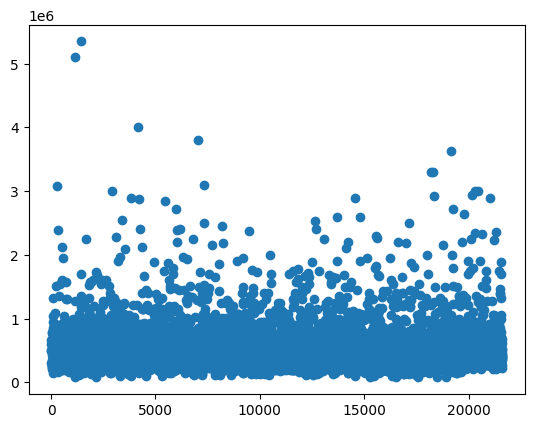

In [80]:
plt.scatter(x=diagnosis_test.index,y=diagnosis_test)

In [81]:
predictions_test.mean()

542616.6285020267

In [82]:
SSE_model = sum((diagnosis_test - predictions_test)**2)
SSE_mean = sum((diagnosis_test - diagnosis.mean())**2)

1 - SSE_model/SSE_mean

-0.01675411484570888